# Imports

In [1]:
# ROS
import sys
import copy
import rospy
import moveit_commander
import moveit_msgs.msg
import geometry_msgs.msg
import open_manipulator_msgs.msg

from std_msgs.msg import String
from moveit_commander.conversions import pose_to_list
from open_manipulator_msgs.srv import *

# Camera 
import pyrealsense2 as rs

# General
import time
import os
import glob
import matplotlib.pyplot as plt
from math import pi

# Image processing
import numpy as np
import cv2
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import PIL
from PIL import Image

# Neural network
import torch
import torch.nn as nn
import torch.nn.functional as F


#First neural network (is there a digit on the picture taken?)

In [172]:
class MLPDecider(nn.Module):
    
  def __init__(self):
    super(MLPDecider, self).__init__()
    self.lin1=nn.Linear(28*28, 300)
    self.lin2=nn.Linear(300, 80)
    self.lin3=nn.Linear(80, 10)
    self.lin4=nn.Linear(10, 2)
    self.dropout = nn.Dropout(0.3)
    self.batchn=nn.BatchNorm2d(1)
        
  def forward(self, x):
        
    temp=x
    temp=self.batchn(temp)
    temp=self.dropout(temp)
    temp=temp.view((temp.shape[0], 28*28))
    temp=self.lin1(temp)
    temp=F.relu(temp)
    temp=self.lin2(temp)
    temp=F.relu(temp)
    temp=self.lin3(temp)
    temp=F.relu(temp)
    temp=self.lin4(temp)
    out=temp
       
    return out

def loadMLP():
  net=MLPDecider()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  net.to(device)
  num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
  NetData=torch.load('MLPDeciderData.pth', map_location=torch.device('cpu')) #the file is in the public google drive, Code section. If you dont finf it ask Richard, he has it on his notebook as well
  net.load_state_dict(NetData)
  net.eval()
  return net

In [89]:
def DigitOrNot(image):
  '''input: a 28*28 torch tensor'''
  image=image.view(1, 1, 28, 28) #nn needs this 
  #print("torch tensor", image)
  net=loadMLP()
  out=net.forward(image)
  pred=torch.argmax(out)
  if pred==0:
    print("Waiting for a number! Insert Object!")
    return False
  elif pred==1:
    print("Found number!")
    return True

# Convolutional Neural Network (digit recognition)

In [4]:
# Define the neuronal network
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    #784
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)                  
    self.pool = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
    self.fc1 = nn.Linear(32 * 7 * 7, 400) 
    self.fc2 = nn.Linear(400, 200)
    self.fc3 = nn.Linear(200, 10)
    self.drop = nn.Dropout(p=0.5)
    self.batchn = nn.BatchNorm2d(32)

  def forward(self, x):
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    out = self.batchn(out)
    out = self.drop(out)
    out = out.view(-1,32*7*7)
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out)   
    

    return out

#load the trained network. The command: Netdata=torch.load('MNISTCNNcheckpoint.pth', map_location=torch.device('cpu')) 
#is where you select the file with the data you wanna load. Make sure the file has the name it has in the command and is in the same folder as this program
#I uploaded the file I used in this code, it is from the MNIST CNN in the dropbox. I only trained for 3 epochs, feel free to you use you own longer trained one!

net = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
Netdata=torch.load('CNNMNIST2.pth', map_location=torch.device('cpu'))
net.load_state_dict(Netdata)
net.eval


def runCNN(imageMatrix):
  out=net.forward(imageMatrix) #calculating the output
  out=torch.argmax(out) #here we check which number the network actually predicted
  return int(out)

# Detect with camera


In [5]:
def captureImage():

    pipeline = rs.pipeline()
    config = rs.config()

    config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 6)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 6)

    profile = pipeline.start(config)
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_scale = depth_sensor.get_depth_scale()

    # We will be removing the background of objects more than
    #  clipping_distance_in_meters meters away
    clipping_distance_in_meters = 1.5 
    clipping_distance = clipping_distance_in_meters / depth_scale

    align_to = rs.stream.color
    align = rs.align(align_to)

    frames = pipeline.wait_for_frames()

    aligned_frames = align.process(frames)
    aligned_depth_frame = aligned_frames.get_depth_frame()
    color_frame = aligned_frames.get_color_frame()

    color_image = np.asanyarray(color_frame.get_data())

    """
        Other functionalities that we do not use (3D images...)
        
    depth_image = np.asanyarray(aligned_depth_frame.get_data())
    # Remove background - Set pixels further than clipping_distance to grey
    grey_color = 153
    depth_image_3d = np.dstack((depth_image,depth_image,depth_image)) #depth image is 1 channel, color is 3 channels
    bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), grey_color, color_image)
    # Render images
    depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
    images = np.hstack((bg_removed, depth_colormap))
    cv2.namedWindow('Align Example', cv2.WINDOW_AUTOSIZE)
    """
    # Filename 
    imageName1 = './pics/realsense' + str(time.strftime("%Y_%m_%d_%H_%M_%S")) +  '_Color.jpg'

    # Saving the image 
    cv2.imwrite(imageName1, color_image) 

    key = cv2.waitKey(1)
    # Press esc or 'q' to close the image window
    cv2.destroyAllWindows()

    pipeline.stop()
    return color_image

## Image processing

In [163]:
def image_processing(image):

    cv2.resize(image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    image = cv2.medianBlur(image,5)
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image=grayImage

    # This part only is for visualization purpose, thresholds comparison
    # We ended up only using the grayscale original image
    ret,th1 = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
    th2 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,2)

    th3 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY,11,2)
    titles = ['Original Image', 'Global Thresholding (v = 127)',
                'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
    images = [image, th1, th2, th3]
    for i in range(4):
        plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])

    print("Image shape: ", image.shape)
    
    # Inverting the greyscale image
    image = cv2.bitwise_not(image)

    # Show the entire processed picture
    print("Processed picture: ")
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(image)

    #take the part of the picture which contains the number (it just takes the hard coded coordinates regardless of the picture, cause most of the time the number is gonna be in the middle)
    tempIM=np.asarray(image)
    print(tempIM.shape)
    woIM=tempIM[0:418,0:418] #you might have to change these numbers for getting the number in. It is important that their distance is always 112. 

    #downscale the image
    woIMre=cv2.resize(src=woIM, dsize=(28,28))
    print(woIMre.shape)

    # Show the selected part of the downscaled image
    print("Selected part (downscaled image: ")
    plt.figure(figsize=(50,8))
    plt.axis('off')
    plt.imshow(woIMre)
    save=woIMre

    '''Wz use 255 as the norm because the tensors of the pictures my camera takes contain numbers from 0 to 255, but the CNN only works well for
    matrixes with numbers im between 0 and 1. so you might need to change this depending on you camera, just make sure the matrix immediently before you
    put into the networks does not contain numbers higher than one and no 'nan' values'''
    norm=255
    woIMre=woIMre/norm
    
    # Zeroing the background to remove artifacts
    woIMre=np.reshape(woIMre, [28, 28])
    for i in range(woIMre[0].size):
        for j in range(woIMre[0].size):
            if i<=14:
                if woIMre[i][j]<=0.5:
                    woIMre[i][j]=0
            else:
                if woIMre[i][j]<=0.5:
                    woIMre[i][j]=0
    plt.figure(figsize=(50,8))
    plt.axis('off')
    plt.imshow(woIMre)

    # Reshaping the input data so the network can process it.
    woIMre=np.reshape(woIMre, [1, 1, 28, 28])
    # Transforming the input into a pytorch datatype so the network can process it
    woIMre=torch.tensor(woIMre)
    woIMre=woIMre.float() # Network wants float, so we give it float
    return woIMre

In [176]:
def detectNumber():
    image_matrix = image_processing(captureImage()) # Capture and process image to matrix
    numberInImage =DigitOrNot(image_matrix) # Use perceptron to scan for number
    number = runCNN(image_matrix) # Use CNN to classify number on image
    if numberInImage: 
        print("There is an object and it seems to be labelled: ", number)
    else: print("No object...For now!")
    return numberInImage, number


# Moveit moving code

In [145]:
home = [0, -1.052, 0.354, 0.703]
init = [0, 0, 0, 0]
photo_pos = [0, 0.293, -0.8, 2] #To change for the photot to be angled
grab_pos2 = [0.3, 0.4, .1, .8]

box1 = [-1.5, 0.293, -0.4, 1.5]
box2 = [1.5, 0.293, -0.4, 1.5]

# Auxilliary function used to avoid the arm to hit the box from the side
def over_position(position):
  return [position[0], -.4, position[2], position[3]]
print(over_position(grab_pos2))

[0.3, -0.4, 0.1, 0.8]


In [150]:
class MoveGroupPythonInterface(object):
    def __init__(self):
        super(MoveGroupPythonInterface, self).__init__()
        moveit_commander.roscpp_initialize(sys.argv)
        rospy.init_node('move_group_python_interface_tutorial', anonymous=True) # Change this name
        
        # Instantiate a `RobotCommander`_ object. Provides information such as the robot’s kinematic model and the robot’s current joint states
        robot = moveit_commander.RobotCommander()
        scene = moveit_commander.PlanningSceneInterface()
        arm_group = moveit_commander.MoveGroupCommander("arm")
        gripper_group = moveit_commander.MoveGroupCommander("gripper")
        display_trajectory_publisher = rospy.Publisher('/arm_group/display_planned_path',
        moveit_msgs.msg.DisplayTrajectory,
        queue_size=20)
        gripper_group_variable_values = gripper_group.get_current_joint_values()

        planning_frame = arm_group.get_planning_frame()
        eef_link = arm_group.get_end_effector_link()
        group_names = robot.get_group_names()

        verbose = False
        if verbose == True : 
            # Getting Basic Information
            print ("============ Planning frame: %s" % planning_frame)
            print ("============ End effector link: %s" % eef_link)
            print ("============ Available Planning Groups:", robot.get_group_names())
            print ("============ Printing robot state")
            print (robot.get_current_state())

        # Misc variables
        self.box_name = ""
        self.robot = robot
        self.scene = scene
        self.arm_group = arm_group
        self.grippper_group = gripper_group
        self.display_trajectory_publisher = display_trajectory_publisher
        self.gripper_group_variable_values =  gripper_group_variable_values
        self.planning_frame = planning_frame
        self.eef_link = eef_link
        self.group_names = group_names

    def move(self, joint_goal):
        arm_group = self.arm_group
        arm_group.go(joint_goal, wait=True)
        # Calling ``stop()`` ensures that there is no residual movement
        arm_group.stop()
        time.sleep(0.5)
        return 0

    def open_gripper(self):
        gripper_group = self.grippper_group
        gripper_group_variable_values = self. gripper_group_variable_values
        print ("Opening Gripper...")
        gripper_group_variable_values[0] = -0.009
        gripper_group.set_joint_value_target(gripper_group_variable_values)
        plan2 = gripper_group.go()
        gripper_group.stop()
        gripper_group.clear_pose_targets()
        rospy.sleep(0.5)

    def close_gripper(self):
        gripper_group = self.grippper_group
        gripper_group_variable_values = self. gripper_group_variable_values
        print ("Closing Gripper...")
        gripper_group_variable_values[0] =  -00.003
        gripper_group.set_joint_value_target(gripper_group_variable_values)
        plan2 = gripper_group.go()
        gripper_group.stop()
        gripper_group.clear_pose_targets()
        rospy.sleep(0.5)



In [153]:
def reposition(number, MoveGroupInterface):
  
  MoveGroupInterface.move(over_position(grab_pos2))

  MoveGroupInterface.move(grab_pos2)
  MoveGroupInterface.close_gripper()

  if number%2 == 0:
    drop_pos = box1
  else:
    drop_pos = box2
  over_drop = over_position(drop_pos)

  MoveGroupInterface.move(home) 
  MoveGroupInterface.move(drop_pos)
  MoveGroupInterface.open_gripper()
  MoveGroupInterface.move(over_drop)
  MoveGroupInterface.move(home)

# Run robot

In [122]:
def main():
  try:
    
    MoveGroupInterface = MoveGroupPythonInterface()
    
    MoveGroupInterface.move(photo_pos)
    MoveGroupInterface.open_gripper()
    #numberInImage, number = detectNumber()
    numberInImage = True
    number = 1
    
    if numberInImage:
      reposition(number, MoveGroupInterface)
  
  except rospy.ROSInterruptException:
      return "ROS interrupt"
  except KeyboardInterrupt:
      return "Keyboard interrupt"

In [170]:
def main_vision():
  try:
    
    #MoveGroupInterface = MoveGroupPythonInterface()
    
    #MoveGroupInterface.move(photo_pos)
    #MoveGroupInterface.open_gripper()
    numberInImage, number = detectNumber()

  
  except rospy.ROSInterruptException:
      return "ROS interrupt"
  except KeyboardInterrupt:
      return "Keyboard interrupt"

./pics/realsense2022_12_04_15_14_21_Color.jpg
Original picture taken by the Intel Realsense camera
(720, 1280)


/tmp/ipykernel_14983/3414722319.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')


(720, 1280)
(418, 418)
(28, 28)
torch tensor tensor([[[[0.5765, 0.5765, 0.5765, 0.5725, 0.5647, 0.5725, 0.5686, 0.5725,
           0.5647, 0.5686, 0.5647, 0.5725, 0.5686, 0.5647, 0.5725, 0.5608,
           0.5608, 0.5647, 0.5608, 0.5569, 0.5647, 0.5686, 0.5647, 0.5608,
           0.5569, 0.5647, 0.5647, 0.5608],
          [0.5961, 0.6000, 0.5961, 0.6000, 0.6000, 0.5882, 0.5804, 0.5765,
           0.5765, 0.5765, 0.5725, 0.5765, 0.5725, 0.5765, 0.5686, 0.5647,
           0.5608, 0.5451, 0.5294, 0.5176, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.5647, 0.5725, 0.5608, 0.5569, 0.5255, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

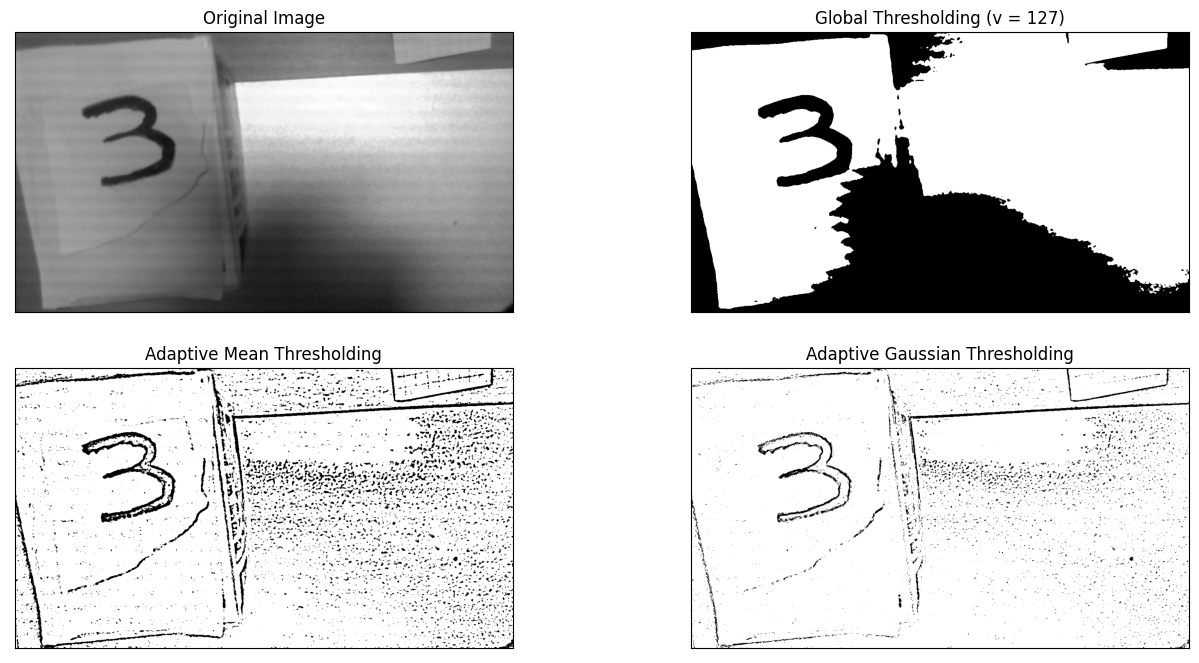

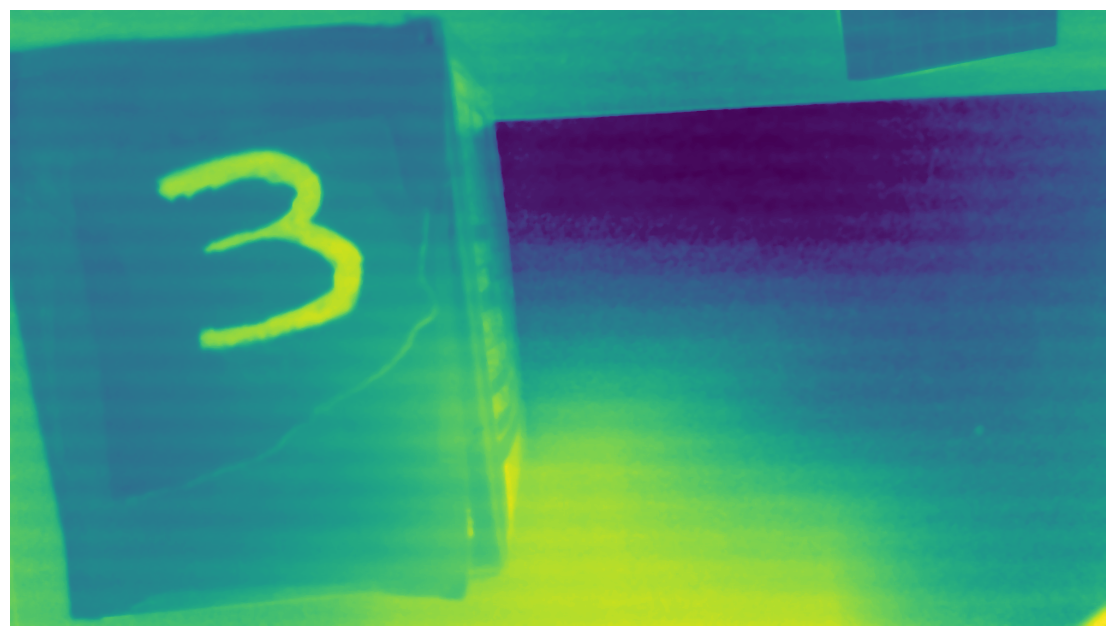

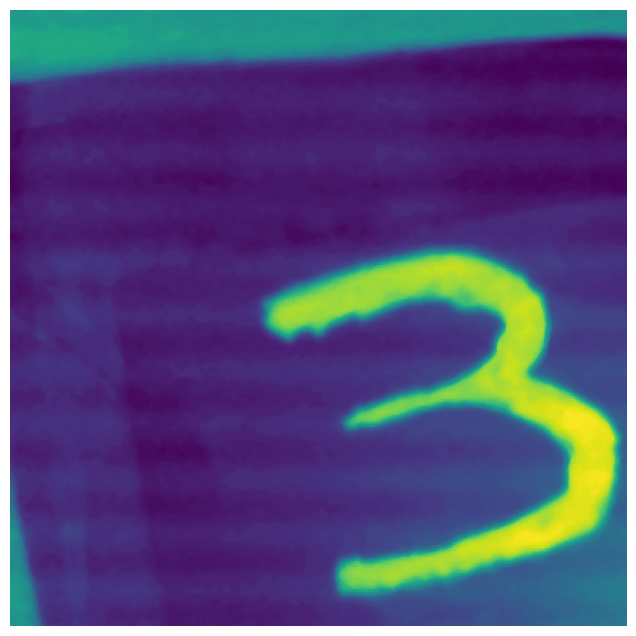

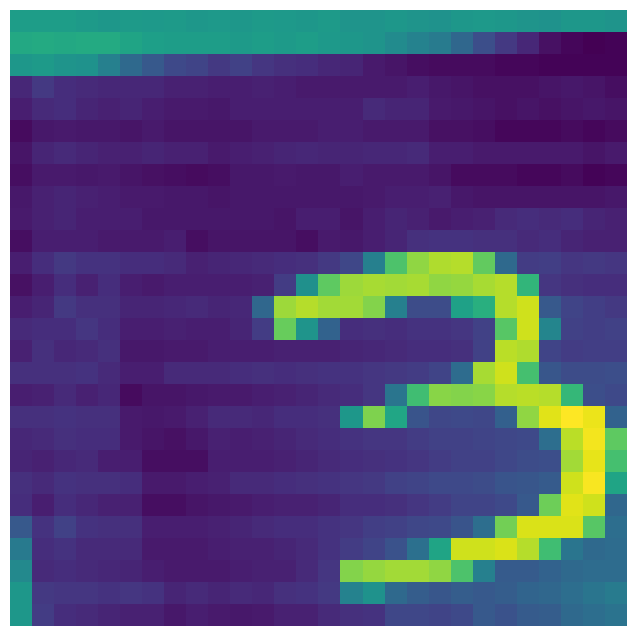

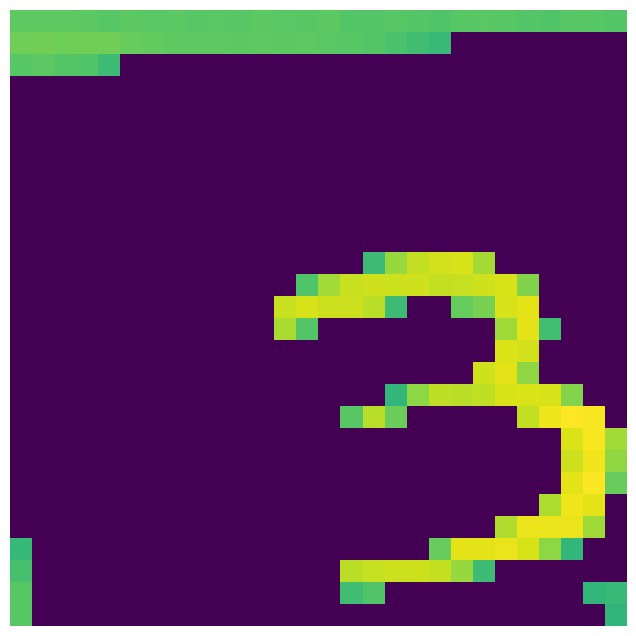

In [183]:
main()